# Basic settings

In [4]:
import config                     # author's personal configuration. Please remove and use your own preferences

%matplotlib inline                

# Survey settings

In [5]:
import survey_model as survey

The module `survey_model` contains three fundamental aspects of the data set to be studied:
- The path to your source code, the input data and to the directories where you want to save your outputs
- The Instrument Model (IMO) for the experiment. Currently we are using the LiteBIRD IMO version 1 stored in `instrument_LB_IMOv1.npy`. Please modify if your data/instrument has different specifications. 
- A routine `load_LiteBIRD_map` to read the LiteBIRD maps including useful information such as central frequency, FWHM and so on.


In [12]:
survey.IMO['LB_LFT_40']['freq']  # This is an example of how the IMO information can be accessed

<Quantity 40. GHz>

This is an example of how to read a LiteBIRD map. The map contains *I*, *Q*, *U* extensions.

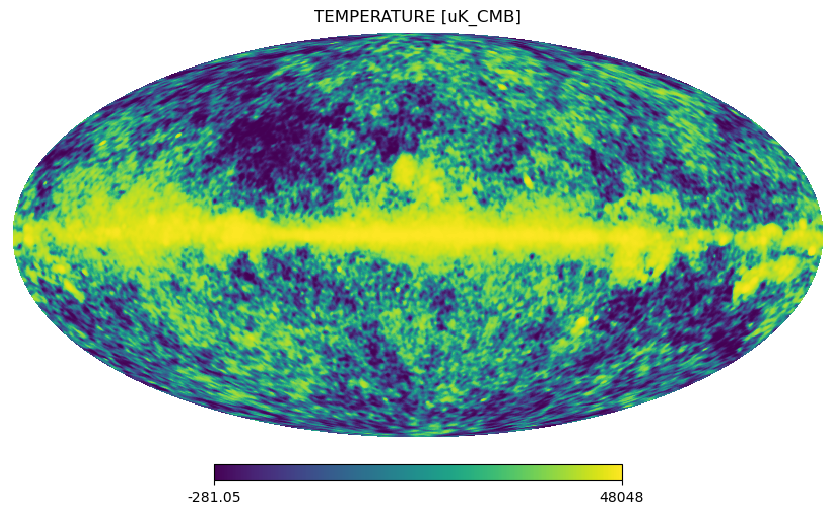

In [18]:
chan_name   = 'LB_LFT_40'  
                # this string specifies the name of the LiteBIRD channel to be read
totmap_file = survey.data_dir+chan_name+'_testing_map_0000_PTEP_20200915_compsep.fits'  
                # the map I'm reading (please change to your file)
    
map40       = survey.load_LiteBIRD_map(totmap_file,chan_name=chan_name)

map40[0].moll() # visualization of the map of temperatures, just for the fun


The map we have loaded includes not only the HEALPix data, but also useful information such as the beam FWHM:

In [30]:
import astropy.units as u         # physical units (just to illustrate how the beam can be expressed in different units)

print('FWHM (Stokes I) = {0} = {1} = {2}'.format(map40.fwhm[0],map40.fwhm[0].to(u.arcmin),map40.fwhm[0].to(u.deg)))


FWHM (Stokes I) = 0.020507618710933373 rad = 70.50000000000001 arcmin = 1.175 deg


# How to generate a catalogue of point source candidates

The high-level routines for catalogue extraction are found in `IFCAPOL_catalogue.py`

In [31]:
from IFCAPOL_catalogue   import blind_survey,non_blind_survey

### 1. Blind search

The first step is to run a blind search of candidates in the Stokes *I* map. This is achieved by the `blind_survey` routine. This routine needs as inputs the map we have loaded, the beam FWHM and, file name for the file where the output catalogue is stored and, optionally, the value of the detection threshold for the detection (in sigma units). When not provided in the call, the default value for `threshold` is 3.0.  

In [36]:
fwhm         = map40.fwhm[0]   # The code understands all astropy angular units (u.rad, u.deg, u.arcmin...)
cat_filename = '/Users/herranz/Desktop/blind_cat.fits'  # change at will

blind_cat    = blind_survey(map40[0],fwhm,cat_filename,threshold=3.0) 
               # It is important to give only the Stokes *I* map (map40[0]) to `blind_survey`.
               # Depending on your computer, this blind catalogue may take a few minutes to run. 

Writing temporary file  /Users/herranz/Temp/032d9c65-ce1b-4d2a-907a-93d5bafc71cb.fits
Deleting temporary file /Users/herranz/Temp/032d9c65-ce1b-4d2a-907a-93d5bafc71cb.fits


In [39]:
blind_cat    # This shows as an example the first rows of the blind catalogue we have just generated

I,J,Intensity,Intensity error,SNR,RA,DEC,Dist [deg]
,,,,,,,deg
float64,float64,float64,float64,float64,float64,float64,float64
107.0,104.0,6923.522603550837,100.63183154799852,68.80052262835457,83.87080614593782,-5.363739124328547,6.6946615144930375
27.0,31.0,24308.53522723542,398.5214425274621,60.99680627739452,275.0191439160836,-16.0739984345757,5.659007334845661
25.0,28.0,9166.5706652958,152.4589799409447,60.124832717931675,290.72792244481684,14.277087259011209,6.055318784498433
18.0,104.0,7316.317673635325,123.08127024195376,59.44298152962569,83.8883526927466,-5.358134838399028,6.946521199041243
26.0,37.0,11394.939822486927,193.36628158529368,58.92930106048831,155.85434562931943,-57.83356363381742,5.322831078325872
74.0,25.0,5792.344700653268,98.60182194065446,58.744803966599214,83.52722092871228,21.93988889506871,4.600674031473511
28.0,108.0,22391.37412936747,392.8688296318873,56.99452957453478,161.19582958481388,-59.703007886106526,6.482488549446769
109.0,28.0,9517.259545515542,193.90404560441732,49.082315512548185,290.75868524379166,14.25650787086741,6.570367005854251


### 2. Non-blind search

The blind catalogue may contain a significan number of repeated source candidates that appear in the regions where the grid of square patches in which the sky is subdivided overlap. A non-blind search using the output catalogue from the blind search refines the catalogue and removes potential repetitions:

In [ ]:
nonblind_cat = non_blind_survey(map40,cat_filename,clean_mode='after')
               #
               #   This routine takes as arguments the same LiteBIRD map (please note that this time
               #  we use the full map, that is, the three Stokes I,Q,U parameters) and same output 
               #  catalogue file name (a string will be added for the final output). The clean_mode
               #  parameter can take two values:
               #   - 'after' means that position repetitions are cleaned after the filtering and detection
               #       pipeline is run over all the positions in the blind catalogue
               #   - 'before' means that repetitions are cleaned first and then the filtering and detection
               #       is run over the reduced list of candidates. This procedure is faster, but we
               #       nevertheless recommend to run in the more robust 'after' mode.
               #
               #   This routine takes longer runtime than blind_survey because at the end more patches are
               #  projected (one per source candidate), because each patch is now has three components
               #  (I,Q,U), and because apart from the Filtered Fusion detection/estimation technique we
               #  also estimate a Gaussian fit photometry for each source.
               #
        